In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import csv
from datetime import datetime, timedelta
import threading
from scipy import stats

Генерация данных

In [29]:
file_path = "data.csv"
NUM_THREADS = 10
NUM_RECORDS = 10**5

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'numeric_col', 'string_col', 'datetime_col'])


def generate(thread_id, num_records):
    def random_date():    
        return datetime.now() - timedelta(days=random.randint(0, 365*5), 
                                           hours=random.randint(0, 23), 
                                           minutes=random.randint(0, 59), 
                                           seconds=random.randint(0, 59))

    file = open(file_path, mode='a', newline='')
    writer = csv.writer(file)
    for i in range(num_records):
        id = i + 1 + (thread_id * num_records)  
        numeric_col = random.normalvariate(30, 20)
        string_col = ''.join(random.choices(string.ascii_lowercase, k=5))
        datetime_col = random_date()
        
        writer.writerow([id, numeric_col, string_col, datetime_col])
    file.close()

threads = []
num_records_per_thread = int(NUM_RECORDS/NUM_THREADS)

for i in range(NUM_THREADS):
    thread = threading.Thread(target=generate, args=(i, num_records_per_thread))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

In [30]:
df = pd.read_csv('data.csv')

df = pd.concat([df, df.sample(frac=0.1, replace=True)])

df.to_csv('data.csv', index=False)

Процессинг

In [31]:
df = pd.read_csv('data.csv')

df = df.dropna()
df = df.drop_duplicates()
df['datetime_col'] = pd.to_datetime(df['datetime_col'], errors='coerce')

df = df[~df['datetime_col'].dt.hour.between(1, 2)]

df['hour'] = df['datetime_col'].dt.hour

df.to_csv('data.csv', index=False)

Расчет метрик

In [32]:
aggregated_data = df.groupby('hour').agg(unique_string_col=('string_col', 'nunique'),
                                         mean_numeric_col=('numeric_col', 'mean'),
                                         median_numeric_col=('numeric_col', 'median')
                                   ).reset_index()

print(aggregated_data)

    hour  unique_string_col  mean_numeric_col  median_numeric_col
0      0               4079         29.578377           29.431302
1      3               4170         30.511769           30.278135
2      4               4157         30.133422           30.392432
3      5               4155         30.119186           30.166546
4      6               4175         29.387260           29.343814
5      7               4223         30.297628           30.094694
6      8               4152         29.972250           29.951820
7      9               4230         30.035139           29.947427
8     10               4092         29.692148           29.610861
9     11               4160         29.941258           29.825943
10    12               4100         29.920907           29.846516
11    13               4128         29.943807           29.948051
12    14               4172         30.602750           30.229513
13    15               4213         30.319898           30.228285
14    16  

SELECT EXTRACT(HOUR FROM datetime_col) AS hour,
       COUNT(DISTINCT string_col) AS unique_string_col,
       AVG(numeric_col) AS mean_numeric_col,
       PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY numeric_col) AS median_numeric_col
FROM df
WHERE EXTRACT(HOUR FROM datetime_col) NOT BETWEEN 1 AND 2
GROUP BY EXTRACT(HOUR FROM datetime_col)
ORDER BY hour;

Мерж с метриками

In [33]:
merged_data = pd.merge(df, aggregated_data, on='hour', how='left')

merged_data.to_csv('merged_data.csv', index=False)

Аналитические метрики

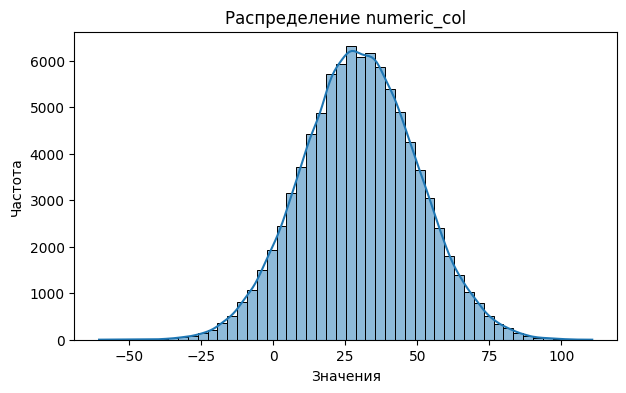

In [34]:
plt.figure(figsize=(7,4))
sns.histplot(df['numeric_col'], kde=True, bins=50)
plt.title('Распределение numeric_col')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

In [35]:
mean_numeric = np.mean(df['numeric_col'])
std_numeric = np.std(df['numeric_col'], ddof=1)

n = len(df['numeric_col'])

confidence_level = 0.95
alpha = 1 - confidence_level
df_t = n - 1

confidence_interval = stats.t.interval(confidence_level, df_t, loc=mean_numeric, scale=std_numeric/np.sqrt(n))

print(f"Среднее значение: {mean_numeric:.2f}")
print(f"95% доверительный интервал: [{confidence_interval[0]} ; {confidence_interval[1]}]")

Среднее значение: 30.03
95% доверительный интервал: [29.902902511471765 ; 30.16106752819482]


Визуализация

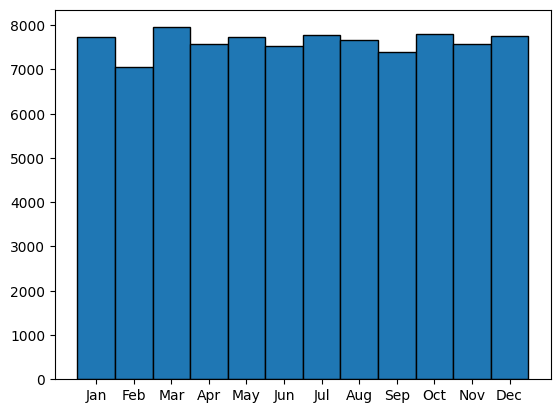

In [36]:
import datetime

df['month'] = df['datetime_col'].dt.month

fig, ax = plt.subplots()
bins = np.arange(1,14)
ax.hist(df['month'], bins = bins, edgecolor="k", align='left')
ax.set_xticks(bins[:-1])
ax.set_xticklabels([datetime.date(1900,i,1).strftime('%b') for i in bins[:-1]])
plt.show()

In [37]:
all_chars = ''.join(df['string_col'])
char_counts = pd.Series(list(all_chars)).value_counts()

char_counts_df = char_counts.reset_index()
char_counts_df.columns = ['char', 'frequency']


In [38]:
heatmap_data = pd.DataFrame(0, index=char_counts_df['char'], columns=char_counts_df['char'])

for string in df['string_col']:
    for char in set(string):
        heatmap_data.loc[char, char] += 1


/var/folders/vg/7pfdh5h54dgcgr036l8_95dw0000gn/T/ipykernel_37476/2324302897.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=char_counts.index, y=char_counts.values, palette='viridis')


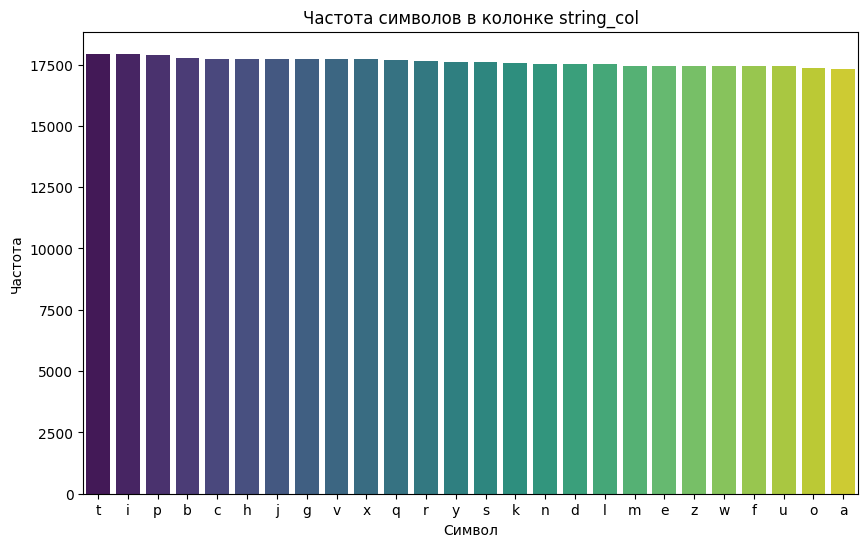

In [39]:
plt.figure(figsize=(10, 6))
sns.barplot(x=char_counts.index, y=char_counts.values, palette='viridis')
plt.title('Частота символов в колонке string_col')
plt.xlabel('Символ')
plt.ylabel('Частота')
plt.show()